# Action Recognition (detecting actions using Pretrained Newtorks and Transfer Learning)

We classify the human action using base model with transfer learning:
* ResNet v2


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You should use mixed precision if you use TPUs or NVIDIA GPUs with at least compute capability 7.0, as it will improve performance by up to 3x.
# With this policy, layers use float16 computations and float32 variables. Computations are done in float16 for performance, but variables must be kept in float32 for numeric stability.
# IMPORTANT : A softmax activation at the end of the model should be float32.
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Overall Settings

In [2]:
FINE_TUNING_EPOCHS = 12 
TRAINING_EPOCHS = 5
BATCH_SIZE = 32

image_height = 180 
image_width = 300

# Load data

In [3]:
# path to the data files
main_path = "/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition"

# Load data
test_df     = pd.read_csv("/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Testing_set.csv")
training_df = pd.read_csv("/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Training_set.csv")

In [4]:
# Stratified Sampling
# Use groupby and apply to select sample 
# which maintains the population group ratios
valid_df = training_df.groupby('label').apply(lambda x: x.sample(frac=0.10))
# There is one problem though - groupby() has added island as an index. 
# Let’s drop the extra index using the Pandas__ method droplevel()__. Pass the parameter 0 as we want to drop the top level index.
valid_df = valid_df.droplevel(0)
# Creating dataframe with
# rest of the 90% values
train_df = training_df.drop(valid_df.index)

In [5]:
training_df.head()

,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop
2,Image_3.jpg,hugging
3,Image_4.jpg,sleeping
4,Image_5.jpg,using_laptop


In [6]:
freq = training_df['label'].value_counts()
train_freq = train_df['label'].value_counts()
valid_freq = valid_df['label'].value_counts()

print(freq,"\n\n", train_freq,"\n\n",valid_freq)
print()

sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: label, dtype: int64 

 sitting               756
hugging               756
sleeping              756
using_laptop          756
drinking              756
clapping              756
cycling               756
calling               756
laughing              756
eating                756
fighting              756
listening_to_music    756
dancing               756
running               756
texting               756
Name: label, dtype: int64 

 calling               84
clapping              84
cycling               84
dancing               84
drinking              84
eating                84
fighting    

In [7]:
test_df.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


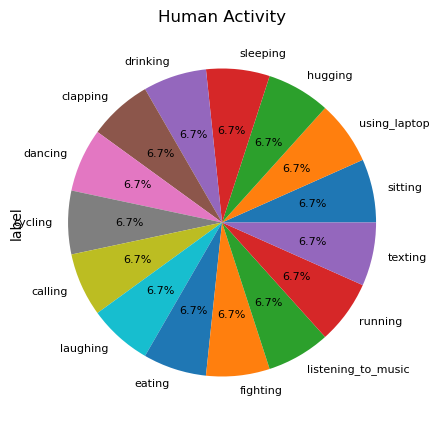

In [8]:
freq.plot(kind='pie',figsize=(5,5),title='Human Activity',autopct='%1.1f%%',shadow = False,  fontsize=8);

# Data Generators

In [9]:
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

In [10]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(rescale         = 1./255.,
                         horizontal_flip = True,
                         vertical_flip   = False,
                         zoom_range      = 0.05,
                         rotation_range  = 25)
 
train_generator = gen.flow_from_dataframe(
    train_df, # dataframe
    directory = main_path + "/train", # images data path / folder in which images are there
    x_col = 'filename',
    y_col = 'label',
    color_mode = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

Found 11340 validated image filenames belonging to 15 classes.


In [11]:
# Data agumentation and pre-processing using tensorflow
test_gen = ImageDataGenerator(rescale = 1./255.)

validation_generator = test_gen.flow_from_dataframe(
    valid_df, # dataframe
    directory   = main_path + "/train", # images data path / folder in which images are there
    x_col       = 'filename',
    y_col       = 'label',
    color_mode  ="rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode  = "categorical",
    batch_size  = BATCH_SIZE,
    shuffle     = False,
    seed        = 42)

test_generator = test_gen.flow_from_dataframe(
    test_df, # dataframe
    directory   = main_path + "/test", # images data path / folder in which images are there
    x_col       = 'filename',
    #y_col       = 'labels',
    color_mode  = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = None,
    batch_size  = BATCH_SIZE,
    shuffle  = False)

Found 1260 validated image filenames belonging to 15 classes.
Found 5400 validated image filenames.


In [12]:
# Get labels in dataset
a = train_generator.class_indices
class_names = list(a.keys())  # storing class/breed names in a list

In [13]:
class_names

['calling',
 'clapping',
 'cycling',
 'dancing',
 'drinking',
 'eating',
 'fighting',
 'hugging',
 'laughing',
 'listening_to_music',
 'running',
 'sitting',
 'sleeping',
 'texting',
 'using_laptop']

In [14]:
a

{'calling': 0,
 'clapping': 1,
 'cycling': 2,
 'dancing': 3,
 'drinking': 4,
 'eating': 5,
 'fighting': 6,
 'hugging': 7,
 'laughing': 8,
 'listening_to_music': 9,
 'running': 10,
 'sitting': 11,
 'sleeping': 12,
 'texting': 13,
 'using_laptop': 14}

In [15]:
# Define function to plot some images
import matplotlib.pyplot as plt

def plot_images(img, true_labels, predictions = None):
    plt.figure(figsize=[12, 18])
    for i in range(24):
        plt.subplot(6, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if (predictions is not None):
            if true_labels is not None:
                plt.title("{}\n {} {:.1f}%".format(class_names[np.argmax(true_labels[i])], class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i])))
            else:
                plt.title("{} {:.1f}%".format(class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i]))) 
        else:
            if true_labels is not None:
                plt.title(class_names[np.argmax(true_labels[i])])    

# Sample Images

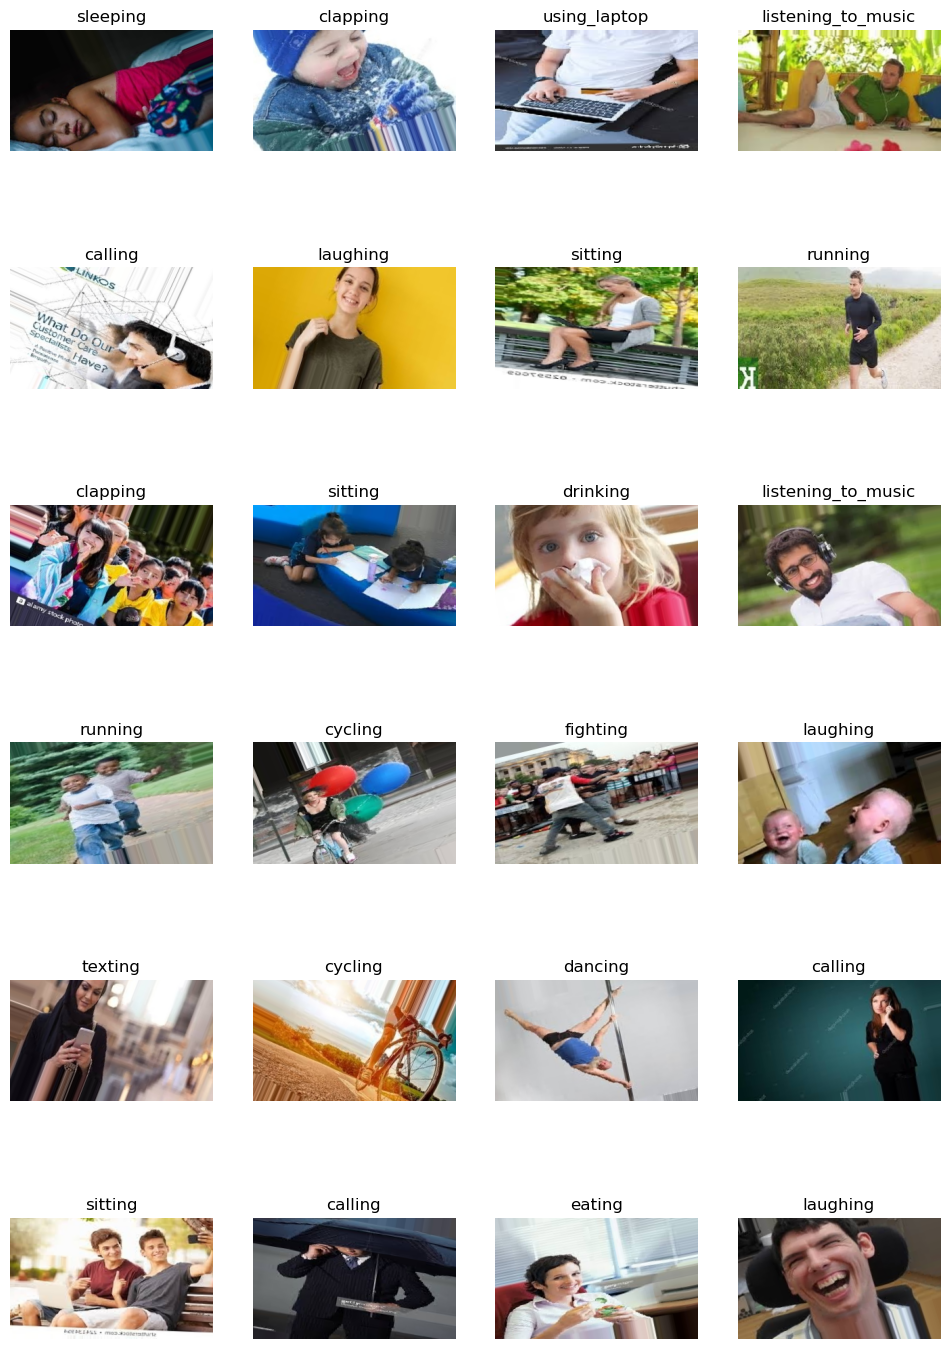

In [16]:
x,y = next(train_generator)
plot_images(x,y)

In [17]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax)
    ax.set_title(title, fontsize = 12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
    ax.set_ylabel('True Label', fontsize= 10)
    ax.set_xlabel('Predicted Label', fontsize = 10)

# Model

In [20]:
from tensorflow.keras.models import Model

def create_model(base_model):
    
    x = base_model.output    
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    
    outputs = Dense(len(class_names), activation='softmax')(x)
    
    model = Model(base_model.inputs, outputs)
    
    return model  

In [21]:
def fit_model(model, base_model, epochs, fine_tune = 0):
    
    early = tf.keras.callbacks.EarlyStopping( patience = 10,
                                              min_delta = 0.001,
                                              restore_best_weights = True)
    # early stopping call back
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    
    print("Unfreezing number of layers in base model = ", fine_tune)
    
    if fine_tune > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False       
        # small learning rate for fine tuning
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        base_model.trainable = False
        model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
       
    # categorical cross entropy is taken since its used as a loss function for
    # multi-class classification problems where there are two or more output labels.
    # using Adam optimizer for better performance
    # other optimizers such as sgd can also be used depending upon the model

    # fit model
    history = model.fit(train_generator,
                        validation_data = validation_generator,
                        epochs = epochs,
                        callbacks = [early])
    
    return history

# Inception

In [22]:
# load the InceptionResNetV2 architecture with imagenet weights as base
inception_base_model = tf.keras.applications.InceptionResNetV2(
                     include_top = False,
                     weights = 'imagenet',
                     input_shape = (image_height, image_width, 3)
                     )

# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
inception_model = create_model(inception_base_model)
inception_model.summary()
# history = fit_model(inception_model, inception_base_model, epochs = TRAINING_EPOCHS)

219055592/219055592 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 89, 149, 32)  864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 89, 149, 32)  96         ['conv2d[0][0]']                 
 alization)                                                                                       
                           

In [ ]:
plot_history(history)

In [23]:
# Unfreeze the base_model
nr_base_layers = len(inception_base_model.layers)
print("Inception base layers = ", nr_base_layers)    

history = fit_model(inception_model, inception_base_model, epochs = FINE_TUNING_EPOCHS, fine_tune = int(nr_base_layers/4))

Inception base layers =  780
Unfreezing number of layers in base model =  195
Epoch 1/12
355/355 [==============================] - 285s 676ms/step - loss: 2.5915 - accuracy: 0.1525 - val_loss: 2.1079 - val_accuracy: 0.4643
Epoch 2/12
355/355 [==============================] - 165s 464ms/step - loss: 2.0411 - accuracy: 0.3907 - val_loss: 1.4190 - val_accuracy: 0.6056
Epoch 3/12
355/355 [==============================] - 164s 462ms/step - loss: 1.6576 - accuracy: 0.5107 - val_loss: 1.1406 - val_accuracy: 0.6817
Epoch 4/12
355/355 [==============================] - 164s 460ms/step - loss: 1.4332 - accuracy: 0.5871 - val_loss: 1.0234 - val_accuracy: 0.7079
Epoch 5/12
355/355 [==============================] - 164s 461ms/step - loss: 1.3048 - accuracy: 0.6302 - val_loss: 0.9426 - val_accuracy: 0.7230
Epoch 6/12
355/355 [==============================] - 165s 465ms/step - loss: 1.2115 - accuracy: 0.6667 - val_loss: 0.8925 - val_accuracy: 0.7484
Epoch 7/12
355/355 [==========================

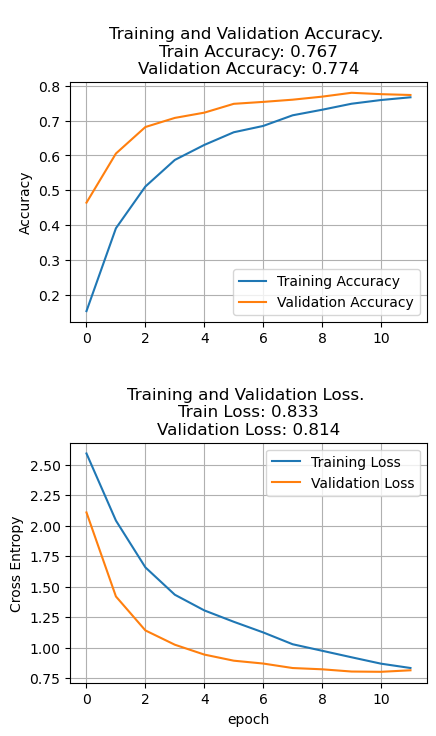

In [24]:
plot_history(history)

In [25]:
accuracy_score = inception_model.evaluate(validation_generator)

print(accuracy_score)
print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))
print("Loss: {:.3f}".format(accuracy_score[0]))

40/40 [==============================] - 5s 117ms/step - loss: 0.8137 - accuracy: 0.7738
[0.813681960105896, 0.773809552192688]
Accuracy: 77.38%
Loss: 0.814


In [26]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
validation_generator.reset()
inception_val_preds = inception_model.predict(validation_generator)
inception_val_pred_classes = np.argmax(inception_val_preds, axis=1)

40/40 [==============================] - 8s 110ms/step


In [27]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
test_generator.reset()
inception_test_preds = inception_model.predict(test_generator)
inception_test_pred_classes = np.argmax(inception_test_preds, axis=1)

169/169 [==============================] - 57s 316ms/step


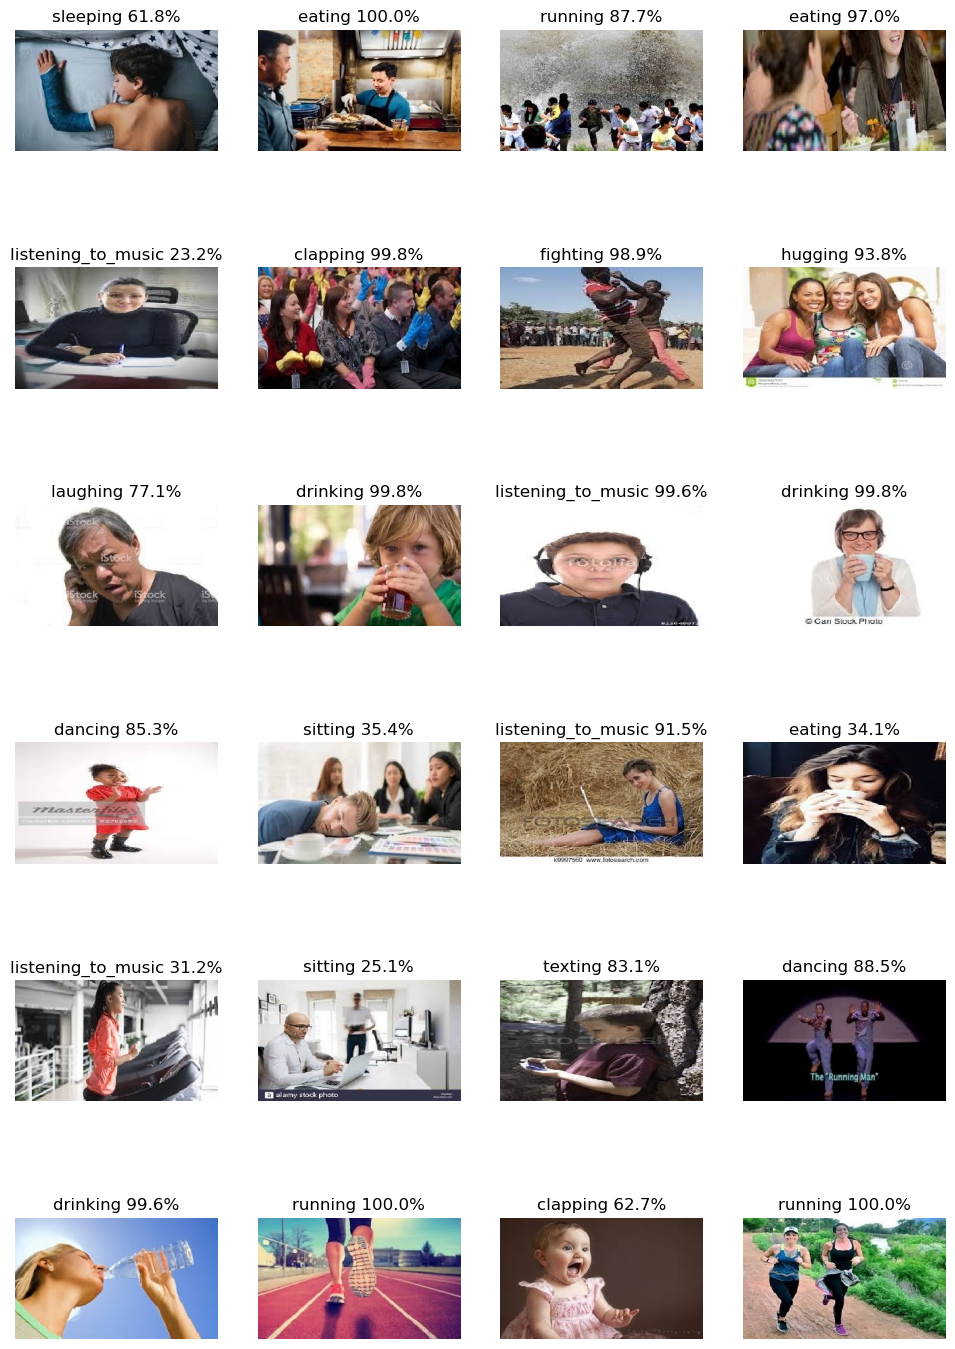

In [28]:
test_generator.reset()
x = next(test_generator)
plot_images(x, None, inception_test_preds)

In [31]:

inception_model.save("/kaggle/working/")